# 12. 프로젝트: End-to-End OCR

keras OCR의 Detector class를 이용해서 이미지 내의 문자 위치를 찾아내는 함수를 만들어보도록 하겠습니다.  
이를 위해서 keras-ocr을 설치해주고 Detector를 만들어주세요. 위의 사진 sample.jpg도 ocr폴더에 다운받으셔야합니다.

## 루브릭


|평가문항|	상세기준|
|:-------|:-------|
|1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.|텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.|
|2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.|학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.|
|3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.|샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.|


* Text Detection : segmentation 기반의 CRAFT를 활용한 keras-ocr 활용
* Text Recognition : keras-ocr을 사용하지 않고 직접 제작


* [참고: OCR with Keras, TensorFlow, and Deep Learning](https://www.pyimagesearch.com/2020/08/17/ocr-with-keras-tensorflow-and-deep-learning/)

## 필요한 라이브러리들을 import 하기

In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_ocr

from keras_ocr.detection import Detector
from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# MJ 데이터셋의 위치 확인
BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME') + '/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR + '/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR + '/MJ/MJ_valid'
TEST_DATA_PATH  = HOME_DIR + '/MJ/MJ_test'

print('train data:', TRAIN_DATA_PATH)
print('valid data:', VALID_DATA_PATH)
print('test  data:', TEST_DATA_PATH)

train data: /home/aiffel-d34j/aiffel/ocr/MJ/MJ_train
valid data: /home/aiffel-d34j/aiffel/ocr/MJ/MJ_valid
test  data: /home/aiffel-d34j/aiffel/ocr/MJ/MJ_test


## Text recognition 

###  Text recognition 모델 구조

* **CRNN의 구조** 
  - **Convolution Layer**를 통해 입력이미지의 Feature를 추출하고
  - **Recurrent Layer**는 추출된 Feature의 전체적인 Context를 파악하고 다양한 output의 크기에 대응
  - **Transcription layer(Fully connected layer)** 는 step마다 어떤 character의 확률이 높은지 예측
  
  
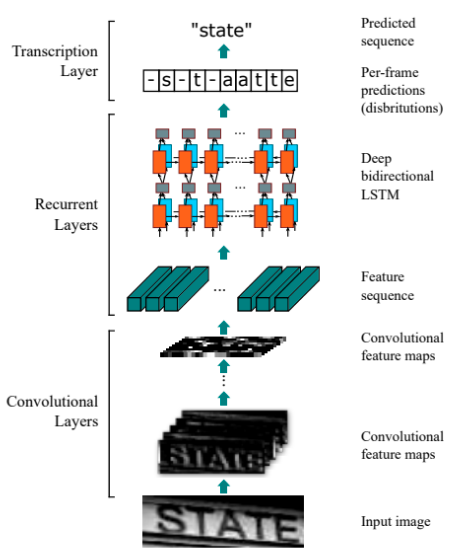

### Text recognition 모델 - (2) Input image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


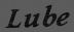

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


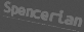

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


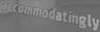

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


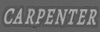

In [3]:
from IPython.display import display

# open database environment
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)


# 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인
with env.begin(write=False) as txn:                  # txn is a Transaction object
    for index in range(1, 5):                        # 4개의 이미지 확인용
        label_key = 'label-%09d'.encode() % index    # 9 digits less than zero fill
        label = txn.get(label_key).decode('utf-8')
        
        img_key = 'image-%09d'.encode() % index      
        imgbuf = txn.get(img_key)
        
        buf = six.BytesIO()   # 텍스트 데이터에 대한 가짜 파일 객체
        buf.write(imgbuf)
        buf.seek(0)           # 첫 줄로 이동
        
        try:
            img = Image.open(buf).convert('RGB')

        except IOError: 
            img = Image.new('RGB', (100, 32))
            label = '-'
            
        width, height = img.size
        print(f'original image width:{width}, height:{height}')
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width, 32)
        
        print(f'target_img_size:{target_img_size}')
        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
       
        print(f'display img shape:{img.shape}')
        print(f'label:{label}')
        
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

* `lmdb.open()` : LMDB 데이터 셋 열기
* `env.begin()` : 트랜잭션 생성
  - 트랜잭션은 읽기-쓰기 또는 읽기 전용 일 수 있으며 읽기-쓰기 트랜잭션은 중첩 될 수 있습니다.
  - 트랜잭션은 한 번에 하나의 스레드에서만 사용해야합니다
  - 읽기 전용 액세스의 경우에도 트랜잭션이 항상 필요합니다

* `label_key = 'label-%09d'.encode() % index` : 
  - 09d : 9 digits less than zero fill
  - [참고](https://www.programmersought.com/article/72963315580/)
  - [참고](https://github.com/clovaai/deep-text-recognition-benchmark/blob/master/dataset.py)

* `six.BytesIO()` : 텍스트 데이터에 대한 가짜 파일 객체입니다. 
  - StringIO.StringIO in Python 2
  - io.StringIO in Python 3.
  - [참고](https://six.readthedocs.io/)

* [LMDB](http://www.lmdb.tech/doc/index.html)
* [MNIST 데이터셋 및 LMDB 준비](https://github.com/DeepLearningStudy/caffe/blob/master/examples/ex3_mnist/caffe_ex3_mnist.md)
* [Creating an LMDB database in Python](http://deepdish.io/2015/04/28/creating-lmdb-in-python/)

In [4]:
# lmdb를 활용하여 케라스 모델 학습용 MJ Synth 데이터셋 클래스 구현
class MJDatasetSequence(Sequence):
    def __init__(self, 
                      dataset_path,        # 읽어들일 데이터셋의 경로
                      label_converter,     # 문자를 미리정의된 index로 변환해주는 converter
                      batch_size=1,
                      img_size=(100,32),   # (width,height), 입력이미지 크기
                      max_text_len=22,     # 필터링을 위한 최대 글자 수
                      is_train=False,      # 학습대상으로 한정하기 위한 flag
                      character=''         # 학습대상
                ):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        
        with self.env.begin(write=False) as txn:
            num_samples = int(txn.get('num-samples'.encode()))
            self.num_samples = int(num_samples)
            self.index_list = [index + 1 for index in range(self.num_samples)]
        
        
    def __len__(self):
        if self.is_train:
            return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    
    # index에 해당하는 image와 label을 가져오는 메소드
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index     # 9 digits less than zero fill 
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index       # 9 digits less than zero fill
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
                
            width, height = img.size   # img_size=(100,32)
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1] )
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()[:self.max_text_len]
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)

        return (img, label)
    
    
    # idx번째 배치를 가져오는 메소드
    def __getitem__(self, idx):
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64')*self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            if len(encoded_label) > self.max_text_len:
                continue
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        return inputs, outputs
        
        
    def on_epoch_end(self):
        self.index_list =  [index + 1 for index in range(self.num_samples)]
        if self.is_train :
            np.random.shuffle(self.index_list)
            return self.index_list

* `.transpose(1,0,2)` : [참고](https://note.nkmk.me/en/python-numpy-transpose/)
  - Transpose **two-dimensional array** (matrix)
    - T attribute
    - ndarray.transpose()
    - np.transpose()
  - **1D array** and row vector, column vector
  - Swap axes of multi-dimensional array (**3D or higher**)
    - Default result
    - Specify axis order with transpose()
    - Example: Transpose multiple matrices at once
  - 입력 파라미터로 (배열(array), 축(axes)-optional)을 받아서 뒤집거나 변경하는 연산을 수행한다.
  - `np.transpose(arr, *axes)`
  - `arr.transpose(*axes)`
  - 파라미터로 지정하지 않을 경우 축의 순서를 반대로 하는 range(a.ndim) [::-1]이 기본값이다.
  - 3차원 데이터를 기준으로 0,1,2를 바꾸고 싶은 방향으로 넣어주면된다.
    - CHW -> HCW 라고 하면, arr.transpose(1,0,2)이 된다
  - [참고](https://go-hard.tistory.com/116)  
    
    
* `re.sub()` : [참고](https://greeksharifa.github.io/정규표현식(re)/2018/08/04/regex-usage-05-intermediate/)
  - 정규식 패턴에 일치되는 문자열은 다른 문자열로 바꿔주는 것
  - 정규식 일치부를 문자열에서 공백으로 바꾸어 주어서 제거
  

### Text recognition 모델 - (3) Encode

In [5]:
class LabelConverter(object):
    """ Convert between text-label and text-index """
    
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
            
    # 각 character를 index 로 변환
    def encode(self, text):
        encoded_label = []
        # [[YOUR CODE]]
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    # 각 index를 character로 변환
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [6]:
# 영문과 숫자에 대한 OCR의 경우 몇 개의 Class가 필요한지 확인
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"  
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


* 문자가 없는 경우를 위해서 공백을 추가할 경우 class의 수는 37개가 됩니다

In [7]:
# Encode한 후 Decode가 정상적으로 되는지 확인
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)

decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


* 동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함됨

### Text recognition 모델 - (4) Build CRNN model

In [8]:
# K.ctc_batch_cost() 를 활용해서 CTC loss를 계산하는 함수
def ctc_lambda_func(args): 
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

* CTC (Connectionist Temporal Classification) 손실 :
  - [참고](https://github.com/hccho2/CTC-Loss)
  - 음성인식이나 문자인식(OCR)에서 target sequence와 output sequence의 길이가 다를 때
    - (정확히는 output의 길이가 target보다 길 때), loss function을 정의하는 방법
  - 합쳐야 하는 character와 합치지 않아야 하는 character를 구분할 필요가 있다
    - output이 만드는 연속된 같은 character는 하나로 합치고(merger), 
    - 실제 연속된 character는 다르게 처리하기 위해 ‘blank’ 개념을 도입한다. 
      - 실제 연속된 character 사이에는 blank를 넣은 형태로 모델이 예측하게 만드는 것이다.
  
* Connectionist Temporal Classification : 
  - [참고1](https://ratsgo.github.io/speechbook/docs/neuralam/ctc)
    - 입력 음성 프레임 시퀀스와 타겟 단어/음소 시퀀스 간에 명시적인 얼라인먼트(alignment) 정보 없이도 음성 인식 모델을 학습할 수 있는 기법
  - [참고2](https://soyoung-new-challenge.tistory.com/16)

In [9]:
# 모델을 만드는 함수 
def build_crnn_model(input_shape = (100, 32, 3), characters = TARGET_CHARACTERS):
    num_chars   = len(characters) + 2
    image_input = layers.Input(shape = input_shape, dtype = "float32", name = "input_image")

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(image_input)
    conv = layers.MaxPooling2D(pool_size = (2, 2))(conv)
    
    conv = layers.Conv2D(128, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)
    conv = layers.MaxPooling2D(pool_size = (2, 2))(conv)
    
    conv = layers.Conv2D(256, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)
    conv = layers.Conv2D(256, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)
    conv = layers.MaxPooling2D(pool_size = (1, 2))(conv)
    
    conv = layers.Conv2D(512, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size = (1, 2))(conv)
    
    feature = layers.Conv2D(512, (2, 2), activation = "relu", kernel_initializer = "he_normal")(conv)
    
    sequnce = layers.Reshape(target_shape = (24, 512))(feature)
    sequnce = layers.Dense(64, activation = "relu")(sequnce)
    
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences = True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences = True))(sequnce)
    
    y_pred = layers.Dense(num_chars, activation = "softmax", name = "output")(sequnce)

    labels       = layers.Input(shape = [22], dtype = "int64", name = "label")
    input_length = layers.Input(shape = [1],  dtype = "int64", name = "input_length")
    label_length = layers.Input(shape = [1],  dtype = "int64", name = "label_length")
    
    loss_out = layers.Lambda(ctc_lambda_func, output_shape = (1, ), name = "ctc")(
        [labels, y_pred, label_length, input_length]
    )
    
    model_input = [image_input, labels, input_length, label_length]
    
    model = Model(
        inputs  = model_input,
        outputs = loss_out
    )
    
    y_func = tf.keras.backend.function(image_input, [y_pred])
    
    return model, y_func

### Text recognition 모델 - (5) Train 

In [10]:
# MJDatasetSequence로 데이터를 적절히 분리하여 데이터셋 구성하기
train_set = MJDatasetSequence(TRAIN_DATA_PATH, 
                              label_converter, 
                              batch_size=BATCH_SIZE, 
                              character=TARGET_CHARACTERS, 
                              is_train=True)

val_set = MJDatasetSequence(VALID_DATA_PATH, 
                            label_converter, 
                            batch_size=BATCH_SIZE, 
                            character=TARGET_CHARACTERS)

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

model, y_func = build_crnn_model()

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [15]:
# 최적화 함수 선택
sgd = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)

# 학습과정 설정
model.compile(optimizer=sgd,
              loss={'ctc': lambda y_true, y_pred: y_pred},
             )

# 체크포인트 설정
ckp = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

# 조기중단 설정
earlystop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='min'
)

# 콜백 리스트
callbacks_list = [ckp, earlystop]


* `clipnorm` :
  - 모든 옵티마이저는 clipnorm과 clipvalue 매개변수를 통해 그래디언트 클리핑(gradient clipping)을 조절할 수 있다.
    - [참고](https://keras.io/ko/optimizers/)
  - RNN계열에서 gradient vanishing이나 gradient exploding이 많이 발생하는데, 
    - gradient exploding을 방지하여 학습의 안정화를 도모하기 위해 사용하는 방법이다.
    - gradient가 일정 threshold를 넘어가면 clipping을 해준다
    - [참고: Gradient clipping(그래디언트 클리핑)](https://sanghyu.tistory.com/87)
    - [참고: 그래디언트 클리핑](https://kh-kim.gitbook.io/natural-language-processing-with-pytorch/00-cover-6/05-gradient-clipping)


* `Adadelta()` :
  - Adagrad, RMSprop, Momentum 모두를 합친 경사하강법이다
  - Adagrad 특징인 모든 step의 gradient 제곱의 합을 window size를 두어
    - window size만큼의 합으로 변경합니다. 
    - 이후 RMSprop과 똑같지 지수이동평균을 적용합니다. 
  - 헤시안(Hessian) 근사법(Approximation)을 이용한 단위(Units) 수정
  - [참고](https://twinw.tistory.com/247)

In [16]:
# 모델 학습 실시
history_ocr_model = model.fit(train_set,
                              steps_per_epoch=len(val_set),
                              epochs=100,
                              validation_data=val_set,
                              validation_steps=len(val_set),
                              callbacks=callbacks_list)

Epoch 1/100
63/63 [==============================] - 14s 145ms/step - loss: 26.8194 - val_loss: 26.2134

Epoch 00001: val_loss improved from inf to 26.21342, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/100
63/63 [==============================] - 8s 133ms/step - loss: 26.3827 - val_loss: 28.3562

Epoch 00002: val_loss did not improve from 26.21342
Epoch 3/100
63/63 [==============================] - 9s 134ms/step - loss: 25.8621 - val_loss: 28.1622

Epoch 00003: val_loss did not improve from 26.21342
Epoch 4/100
63/63 [==============================] - 8s 128ms/step - loss: 25.4276 - val_loss: 25.6278

Epoch 00004: val_loss improved from 26.21342 to 25.62778, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/100
63/63 [==============================] - 8s 129ms/step - loss: 24.7808 - val_loss: 25.2792

Epoch 00005: val_loss improved from 25.62778 to 25.27915, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch

63/63 [==============================] - 8s 131ms/step - loss: 4.4838 - val_loss: 4.4928

Epoch 00039: val_loss improved from 4.66629 to 4.49280, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 40/100
63/63 [==============================] - 9s 135ms/step - loss: 4.3127 - val_loss: 4.5436

Epoch 00040: val_loss did not improve from 4.49280
Epoch 41/100
63/63 [==============================] - 8s 130ms/step - loss: 4.4125 - val_loss: 4.5587

Epoch 00041: val_loss did not improve from 4.49280
Epoch 42/100
63/63 [==============================] - 8s 130ms/step - loss: 4.4099 - val_loss: 4.4041

Epoch 00042: val_loss improved from 4.49280 to 4.40408, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 43/100
63/63 [==============================] - 8s 130ms/step - loss: 4.3028 - val_loss: 4.3381

Epoch 00043: val_loss improved from 4.40408 to 4.33809, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 44/100
63/63 [=======


Epoch 00081: val_loss improved from 3.17610 to 3.11671, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 82/100
63/63 [==============================] - 8s 130ms/step - loss: 2.9554 - val_loss: 3.1693

Epoch 00082: val_loss did not improve from 3.11671
Epoch 83/100
63/63 [==============================] - 9s 136ms/step - loss: 2.9251 - val_loss: 3.0603

Epoch 00083: val_loss improved from 3.11671 to 3.06025, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 84/100
63/63 [==============================] - 8s 130ms/step - loss: 3.0180 - val_loss: 3.0307

Epoch 00084: val_loss improved from 3.06025 to 3.03069, saving model to /home/aiffel-d34j/aiffel/ocr/model_checkpoint.hdf5
Epoch 85/100
63/63 [==============================] - 8s 129ms/step - loss: 2.9070 - val_loss: 3.1194

Epoch 00085: val_loss did not improve from 3.03069
Epoch 86/100
63/63 [==============================] - 9s 144ms/step - loss: 2.7663 - val_loss: 3.0630

Epoch 00086: 

In [17]:
# 학습시킨 모델 저장
model_path = HOME_DIR + '/ocr_model.h5'
model.save(model_path)

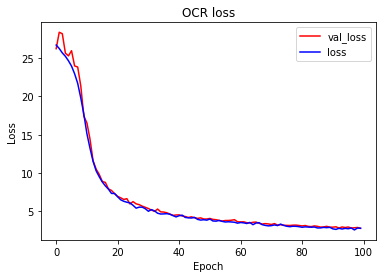

In [18]:
# 훈련 과정 loss 시각화
plt.plot(history_ocr_model.history['val_loss'], 'r')
plt.plot(history_ocr_model.history['loss'], 'b')
plt.title('OCR loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'loss'], loc='upper right')
plt.show()

### Text recognition 모델 - (6) Inference

In [19]:
# 학습한 모델을 테스트셋에서 inference 하기
from IPython.display import display

test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

model, y_func = build_crnn_model()

model.load_weights(checkpoint_path)
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output

model_pred = Model(inputs=input_data, outputs=y_pred)

In [21]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS, top_paths = 1):
    results = []
    beam_width = 5
    if beam_width < top_paths:
        beam_width = top_paths
    for i in range(top_paths):
        indexes = K.get_value(
            K.ctc_decode(
                out, input_length = np.ones(out.shape[0]) * out.shape[1],
                greedy =False , beam_width = beam_width, top_paths = top_paths
            )[0][i]
        )[0]
        text = ""
        for index in indexes:
            text += chars[index]
        results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 SLINKING9999999999999999


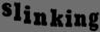

Result: 	 ALEPPO99999999999999999


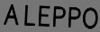

Result: 	 FWANDE999999999999999999


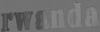

Result: 	 NATHANS99999999999999999


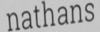

Result: 	 HALLO999999999999999999


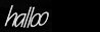

Result: 	 HURLS9999999999999999999


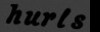

Result: 	 DOWNSIZE9999999999999999


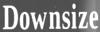

Result: 	 ROBOTIC99999999999999999


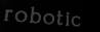

Result: 	 SLOPPY99999999999999999


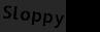

Result: 	 HERMITE99999999999999999


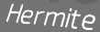

In [22]:
check_inference(model, test_set, index=10)

## Text detection - keras OCR의 Detector class 이용하기

* [참고: 글자를 읽을 줄 아는 인공지능](https://softwareeng.tistory.com/entry/Day49-글자를-읽을-줄-아는-인공지능)
* [참고: keras-ocr](https://keras-ocr.readthedocs.io/en/latest/index.html)
* [참고: keras_ocr/pipeline.py](https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/pipeline.py)
* [참고: EasyOCR](https://github.com/JaidedAI/EasyOCR)
* [참고: CRAFT: Character Region Awareness for Text Detection](https://hellownd.tistory.com/entry/CRAFT-Character-Region-Awareness-for-Text-Detection)
* [참고: Optical Character Recognition (OCR) in Python using keras-ocr](https://www.youtube.com/watch?v=WtEhQvVUdH4)
  - Link to keras-ocr : https://github.com/faustomorales/keras-ocr
  - Link to my notebook : https://github.com/bhattbhavesh91/keras-ocr-demo

### keras OCR의 Detector Class의 instance 생성

In [23]:
SAMPLE_IMG_PATH = 'sample.jpg'

# keras OCR의 Detector Class의 instance 생성
detector = Detector()

Looking for /home/aiffel-d34j/.keras-ocr/craft_mlt_25k.h5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### 이미지 내의 문자 위치를 찾아내는 함수

keras-ocr의 Detector를 이용해서 만들기

* [참고: Free Offline OCR - Text Detection & Recognition](https://www.kaggle.com/anycode/free-offline-ocr-text-detection-recognition)

In [24]:
# 이미지 내의 문자 위치를 찾아내는 함수
def detect_text(img_path):
    # 이미지 불러오기
    img_path = HOME_DIR + '/' + img_path
    img = keras_ocr.tools.read(img_path)

    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img = img[tf.newaxis, :, :, :]
    
    
    # 배치의 첫 번째 결과만 가져옵니다.
    result_img = detector.detect(images=img[0])
    ocr_result = np.array(result_img)
    
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    ocr_result[:, :, :, [1,0]] = ocr_result[:, :, :, [0,1]]
    
    # 단어의 영역 잘라오기
    cropped_imgs = []
    
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

* [NumPy의 axis 변경](https://blog.naver.com/sooftware/221577171997)
* [NumPy 배열로 열 교환](https://pythonq.com/so/python/695544)

### inference한 후에 시각화

In [25]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

ValueError: in user code:

    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:425 call
        inputs, training=training, mask=mask)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/aiffel-d34j/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:239 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer basenet.slice1.0 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 1200, 3)


In [ ]:
cropped_img

In [ ]:
cropped_img[0]

In [ ]:
cropped_img[1]

### Recognition model로 인식하는 함수

In [ ]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    target_img_size = input_img_size
    img = np.array(pil_img.resize(target_img_size)).transpose(1,0,2)

    print(f'label:{label}')

    display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))    
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model_pred.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))    

### 인식 결과 출력

In [ ]:
for _img in cropped_img:
    recognize_img(_img)

## 회고

*  LMDB 데이터 구조에 대해서 좀 더 공부하는 기회가 되었다.

              
* compile 설정할 때에 `metrics=['accuracy']` 옵션을 사용하면 
  - fit한 결과에서 accuracy 값이 0으로 나오는데 원인을 찾아봐야 겠다.